## Problem

 What musical characteristics and external factors are most strongly associated with song's streaming success on Spotify?
- Musical Features 
- Does timing matter?
- Danceability vs Popularity 
- Artist Dynamic



## Data Description
The dataset is from Kaggle's "Most Streamed Spotify Songs 2023" dataset which is a csv file of streaming data and audio features for the most popular tracks of that year


In [ ]:
# Import Packages
import matplotlib.pyplot as plt #for creating charts 
import numpy as np #for numerical operations
import pandas as pd #for working with data in tables
import seaborn as sns #for making nicer looking charts
import statistics #basic stats functions
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler #scaling tool


In [ ]:
# Load dataset
pat_data = pd.read_csv(r"C:\Users\khana\Downloads\Popular_Spotify_Songs.csv", encoding="latin-1") #used latin1 to handle special characters in artist names
pat_data_1=pat_data.copy()
pat_data_clean = pat_data.copy() #Created a copy of the original dataset to clean  

In [35]:
# Look at the first five rows
pat_data.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [ ]:
pat_data.info() #Total number of rows, columns, and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

In [ ]:
print(pat_data.isnull().sum()) #Counts missing values in each column

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64


Streams has commas and object, so changing it to have no commas and num

In [ ]:
pat_data_clean['streams'] = pd.to_numeric(pat_data_clean['streams'].astype(str).str.replace(',', ''),errors='coerce') 

Converting all playlist columns to numbers

In [39]:
playlist_cols = ['in_spotify_playlists', 'in_spotify_charts','in_apple_playlists', 'in_apple_charts','in_deezer_playlists', 'in_deezer_charts','in_shazam_charts']
for col in playlist_cols: 
    pat_data_clean[col] = pd.to_numeric(pat_data_clean[col], errors='coerce')

All songs must have a key, so turning null values to say unknown

In [40]:
pat_data_clean['key'] = pat_data_clean['key'].fillna('Unknown')

In [ ]:
print(pat_data_clean.isnull().sum().sum()) #Total number of missing values across the entire dataset

137


In [ ]:
pat_data_clean = pat_data_clean.drop_duplicates() #Remove duplicates

Percentage columns only have 0 - 100 range

In [ ]:

pct_cols = ['danceability_%', 'valence_%', 'energy_%','acousticness_%', 'instrumentalness_%','liveness_%', 'speechiness_%']
for col in pct_cols:
    pat_data_clean[col] = pd.to_numeric(pat_data_clean[col], errors='coerce')
    pat_data_clean[col] = pat_data_clean[col].clip(0, 100)

Streams in billions divided by billions for readibility in charts


In [44]:
pat_data_clean['streams_billions'] = pat_data_clean['streams'] / 1_000_000_000

Total playlist from all platforms

In [45]:
pat_data_clean['total_playlists'] = (pat_data_clean['in_spotify_playlists'].fillna(0) + pat_data_clean['in_apple_playlists'].fillna(0) + pat_data_clean['in_deezer_playlists'].fillna(0))

Categorizing release month into season

In [ ]:
def get_season(month):  #defines function that turns month numbers into seasons
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
#Applies the get_season function to the released_month column to create a new release_season column
pat_data_clean['release_season'] = pat_data_clean['released_month'].apply(get_season)


if 1 artist, then solo, else collaboration

In [ ]:
#Defines a function that categorizes artists as 'Solo' or 'Collaboration' based on the artist_count column
def categorize_artist(count):
    if count == 1:
        return 'Solo'
    else:
        return 'Collaboration'

pat_data_clean['artist_type'] = pat_data_clean['artist_count'].apply(categorize_artist)

In [ ]:
#Revisiting the first few rows of the cleaned dataset to see the changes
pat_data_clean.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%,streams_billions,total_playlists,release_season,artist_type
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703.0,43,...,89,83,31,0,8,4,0.141382,641.0,Summer,Collaboration
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286.0,48,...,61,74,7,0,10,4,0.133716,1580.0,Spring,Solo
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974.0,94,...,32,53,17,0,31,6,0.140004,1582.0,Summer,Solo
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817.0,116,...,58,72,11,0,11,15,0.800841,8099.0,Summer,Solo
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322.0,84,...,23,80,14,63,11,6,0.303236,3304.0,Spring,Solo


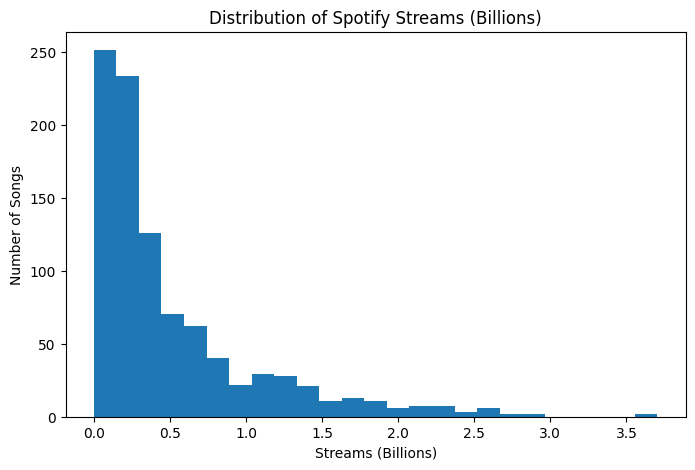

In [ ]:
#Histogram of the distribution of Spotify streams (in billions) to see how the songs are distributed in terms of popularity
plt.figure(figsize=(8,5))
plt.hist(pat_data_clean['streams_billions'], bins=25)
plt.title("Distribution of Spotify Streams (Billions)")
plt.xlabel("Streams (Billions)")
plt.ylabel("Number of Songs")
plt.show()

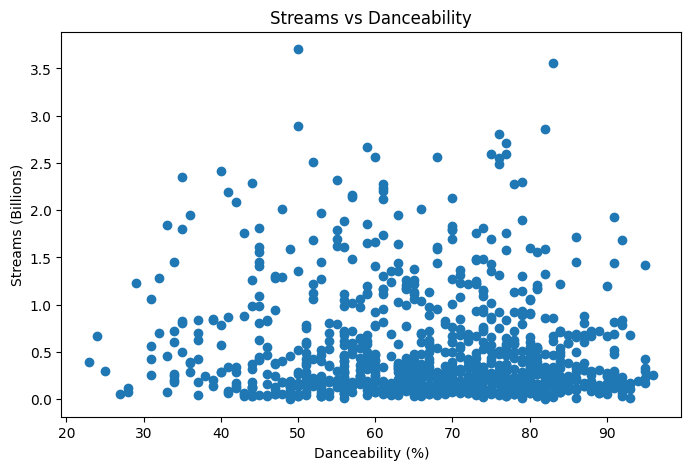

In [ ]:
#Scatterplot to visualize the relationship between danceability and streams (in billions) to see if more danceable songs tend to have more streams
plt.figure(figsize=(8,5))
plt.scatter(
    pat_data_clean['danceability_%'],
    pat_data_clean['streams_billions']
)

plt.title("Streams vs Danceability")
plt.xlabel("Danceability (%)")
plt.ylabel("Streams (Billions)")
plt.show()

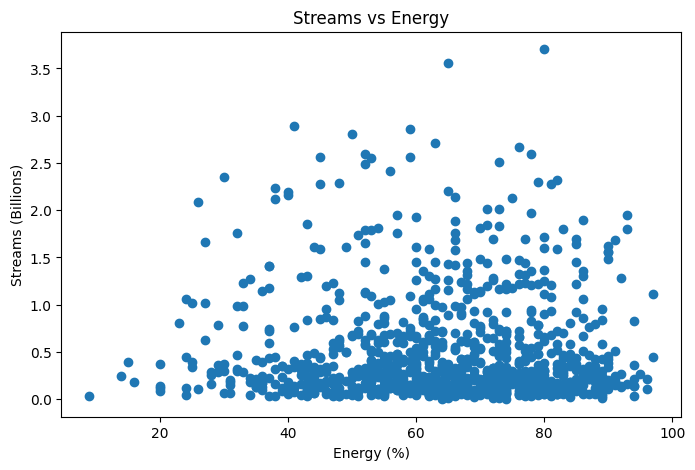

In [ ]:
#Scatterplot to visualize the relationship between energy and streams (in billions) to see if more energetic songs tend to have more streams
plt.figure(figsize=(8,5))
plt.scatter(
    pat_data_clean['energy_%'],
    pat_data_clean['streams_billions']
)

plt.title("Streams vs Energy")
plt.xlabel("Energy (%)")
plt.ylabel("Streams (Billions)")
plt.show()

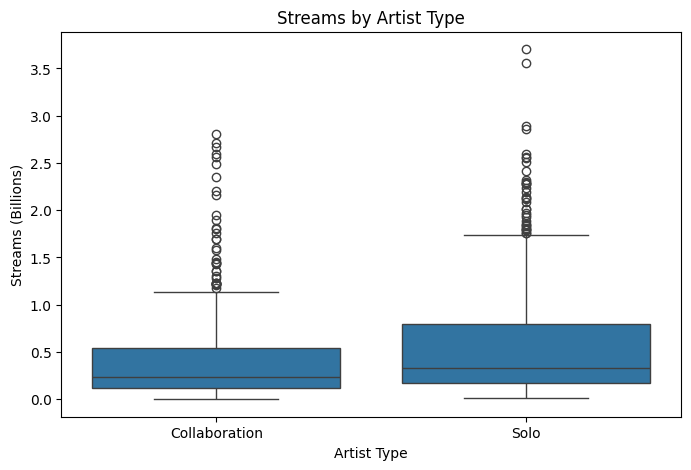

In [ ]:
#Boxplot to compare the distribution of streams (in billions) between solo artists and collaborations to see if one type tends to have more streams than the other
plt.figure(figsize=(8,5))
sns.boxplot(
    x='artist_type',
    y='streams_billions',
    data=pat_data_clean
)

plt.title("Streams by Artist Type")
plt.xlabel("Artist Type")
plt.ylabel("Streams (Billions)")
plt.show()

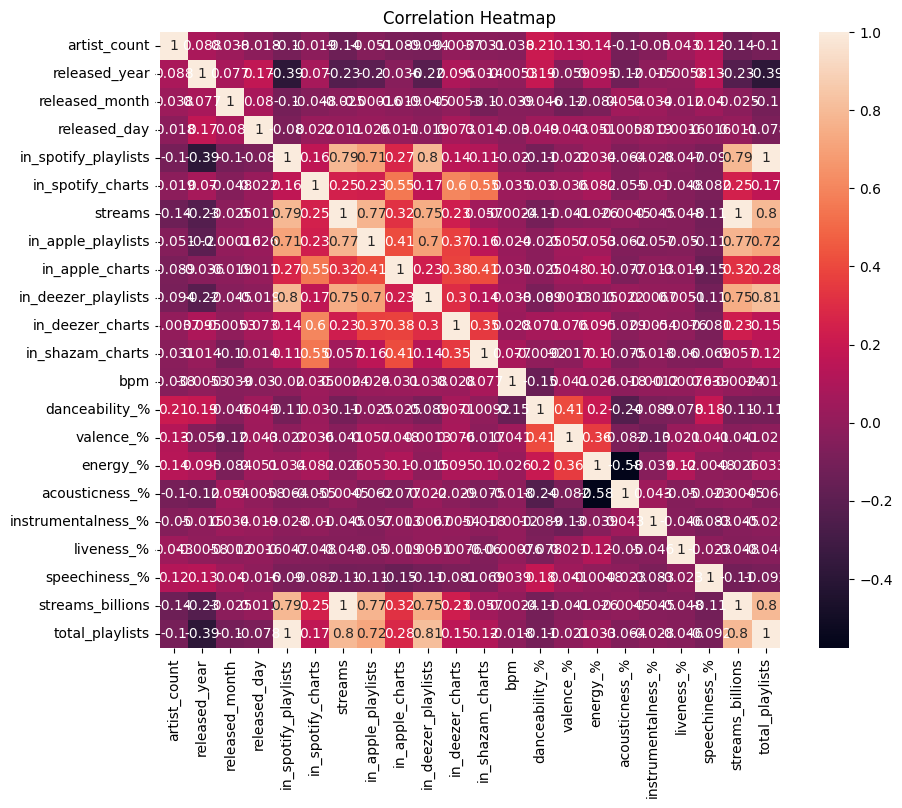

In [ ]:
#Heatmap to visualize the correlations between numeric features in the dataset to see which features are most strongly correlated with streams and with each other
plt.figure(figsize=(10,8))

numeric_data = pat_data_clean.select_dtypes(include=['float64', 'int64'])[[""]]
corr = numeric_data.corr()

sns.heatmap(corr,annot=True)

plt.title("Correlation Heatmap")
plt.show()

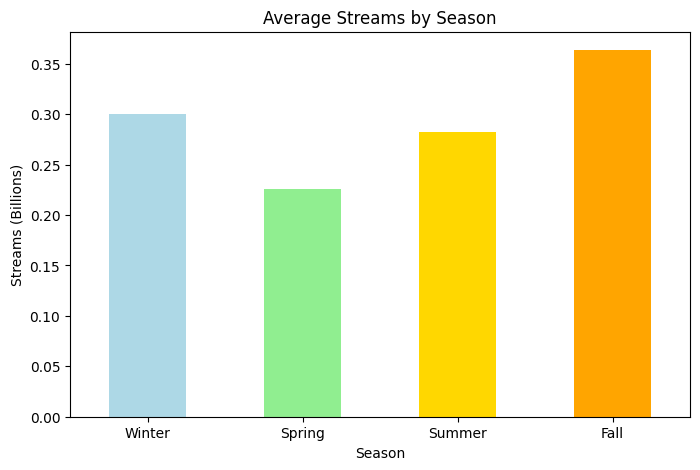

In [67]:
#Bar chart to compare the average streams (in billions) for songs released in each season to see if there are seasonal trends in song popularity
plt.figure(figsize=(8, 5))

season_order = ['Winter', 'Spring', 'Summer', 'Fall']
season_avg = pat_data_clean.groupby('release_season')['streams_billions'].median().reindex(season_order)

season_avg.plot(kind='bar', color=['lightblue', 'lightgreen', 'gold', 'orange'])
plt.title('Average Streams by Season')
plt.xlabel('Season')
plt.ylabel('Streams (Billions)')
plt.xticks(rotation=0) 
plt.show()

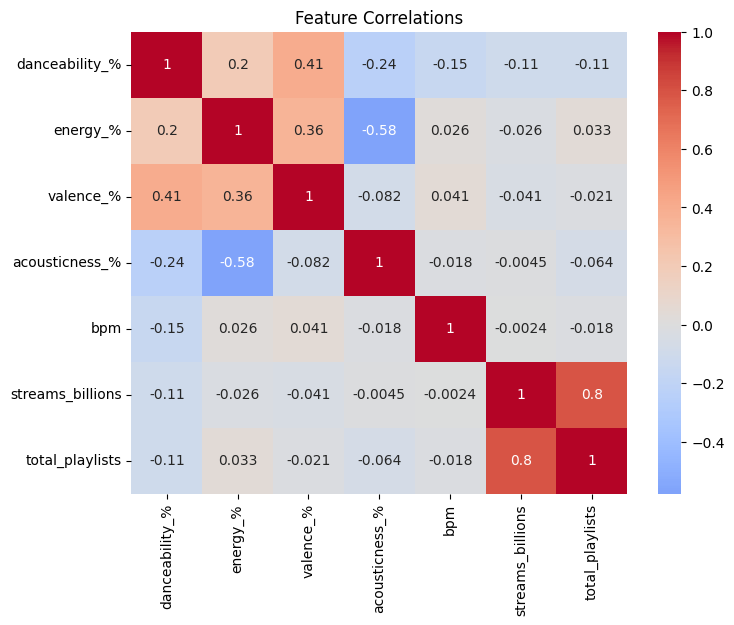

In [68]:
plt.figure(figsize=(8,6))

key_cols = ['danceability_%', 'energy_%', 'valence_%', 'acousticness_%', 
            'bpm', 'streams_billions', 'total_playlists']

corr = pat_data_clean[key_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlations')
plt.show()

C:\Users\khana\AppData\Local\Temp\ipykernel_26308\547262482.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


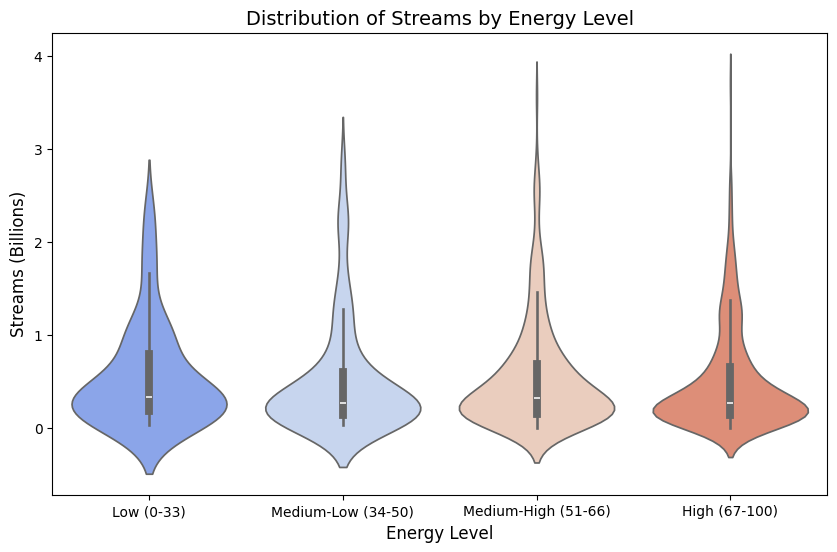

In [74]:
# Create energy groups/categories first
pat_data_clean['energy_group'] = pd.cut(
    pat_data_clean['energy_%'],
    bins=[0, 33, 50, 66, 100],
    labels=['Low (0-33)', 'Medium-Low (34-50)', 'Medium-High (51-66)', 'High (67-100)']
)

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    x='energy_group',
    y='streams_billions',
    data=pat_data_clean,
    palette='coolwarm'
)

plt.title('Distribution of Streams by Energy Level', fontsize=14)
plt.xlabel('Energy Level', fontsize=12)
plt.ylabel('Streams (Billions)', fontsize=12)
plt.show()

C:\Users\khana\AppData\Local\Temp\ipykernel_26308\2256892734.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


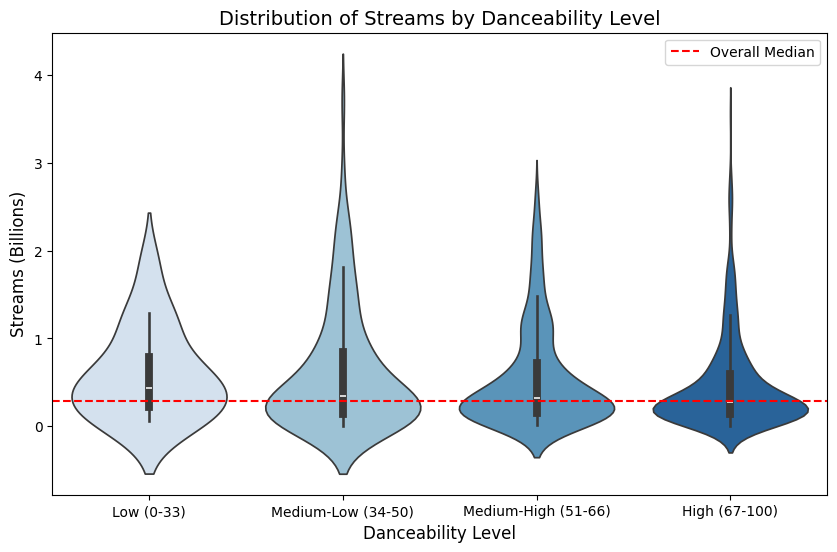

In [77]:
# Create danceability groups
pat_data_clean['dance_group'] = pd.cut(
    pat_data_clean['danceability_%'],
    bins=[0, 33, 50, 66, 100],
    labels=['Low (0-33)', 'Medium-Low (34-50)', 'Medium-High (51-66)', 'High (67-100)']
)

# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    x='dance_group',
    y='streams_billions',
    data=pat_data_clean,
    palette='Blues'
)

plt.axhline(y=pat_data_clean['streams_billions'].median(), 
            color='red', linestyle='--', label='Overall Median')

plt.title('Distribution of Streams by Danceability Level', fontsize=14)
plt.xlabel('Danceability Level', fontsize=12)
plt.ylabel('Streams (Billions)', fontsize=12)
plt.legend()
plt.show()


C:\Users\khana\AppData\Local\Temp\ipykernel_26308\3930090533.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(


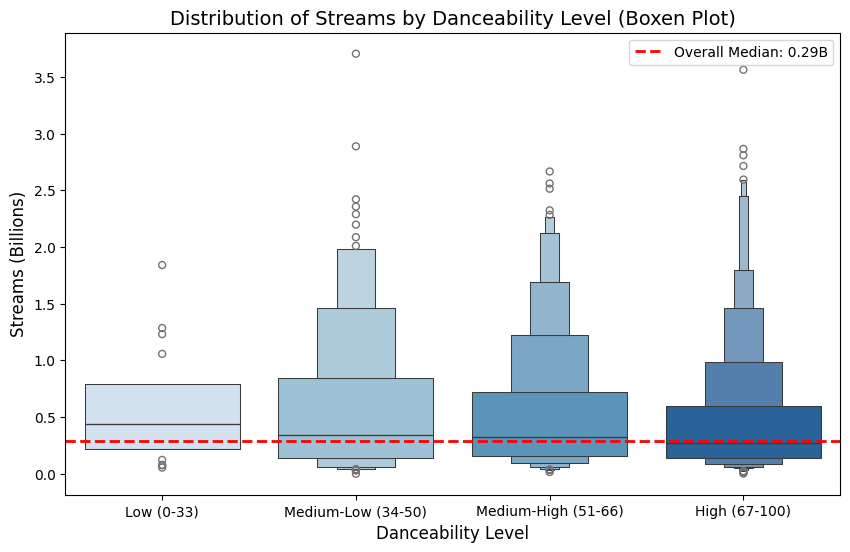

In [79]:
# Create danceability groups
pat_data_clean['dance_group'] = pd.cut(
    pat_data_clean['danceability_%'],
    bins=[0, 33, 50, 66, 100],
    labels=['Low (0-33)', 'Medium-Low (34-50)', 'Medium-High (51-66)', 'High (67-100)']
)

# Boxen plot
plt.figure(figsize=(10, 6))
sns.boxenplot(
    x='dance_group',
    y='streams_billions',
    data=pat_data_clean,
    palette='Blues'
)

plt.axhline(y=pat_data_clean['streams_billions'].median(), 
            color='red', linestyle='--', linewidth=2,
            label=f'Overall Median: {pat_data_clean["streams_billions"].median():.2f}B')

plt.title('Distribution of Streams by Danceability Level (Boxen Plot)', fontsize=14)
plt.xlabel('Danceability Level', fontsize=12)
plt.ylabel('Streams (Billions)', fontsize=12)
plt.legend()
plt.show()